# BPNN
The Behler-Parrinello Neural Network (BPNN) is a machine learning approach used for constructing interatomic potentials. It was introduced by Jörg Behler and Michele Parrinello in 2007 to provide accurate potential energy surfaces (PES) for molecular and condensed-phase systems while maintaining computational efficiency.


- The total energy of a system is expressed as a sum of individual atomic contributions, where each atom's energy is predicted by a neural network based on its local environment.

- Atomic environments are represented using symmetry functions that are invariant to translation, rotation, and permutation of atoms.

- BPNNs are typically trained on reference datasets from Density Functional Theory (DFT) or higher-level quantum mechanical calculations.
This allows them to reproduce quantum accuracy at a much lower computational cost.



In [3]:
from ase.calculators.calculator import Calculator
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim


## Symmetry Functions

In [1]:
# Symmetry Functions
class G1:
    def __init__(self):
        pass

    def __repr__(self):
        return 'G1'

    def __call__(self, **var):
        return torch.sum(var['fc'], dim=-1)


class G2:
    def __init__(self, eta, Rs):
        self.eta = eta
        self.Rs = Rs

    def __repr__(self):
        return 'G2(%.2f, %.2f)' % (self.eta, self.Rs)

    def __call__(self, **var):
        sf = torch.exp(-self.eta * (var['Rij'] - self.Rs) ** 2) * var['fc']
        return torch.sum(sf, dim=-1)


class G4:
    def __init__(self, eta=1., zeta=1., lambd=1.):
        self.eta = eta
        self.zeta = zeta
        self.lambd = lambd

    def __repr__(self):
        return 'G4(%.2f, %.2f, %.2f)' % (self.eta, self.zeta, self.lambd)

    def __call__(self, **var):
        Rij_expanded = var['Rij'].unsqueeze(-1)
        expo = torch.exp(-self.eta * (Rij_expanded + Rij_expanded.transpose(-2, -1)))
        cosin = torch.pow(var['cos'] * self.lambd + 1, self.zeta)
        cutoff = var['fc'].unsqueeze(-1) * var['fc'].unsqueeze(-2)
        sf = torch.sum(torch.sum(2.**(1 - self.zeta) * expo * cutoff * cosin,
                                dim=-1), dim=-1)
        return sf

## Neural Network 

In [4]:
class NeuralNetwork(nn.Module):
    """Neural network model for atomic energy prediction"""
    def __init__(self, input_size, hidden_sizes, output_size, name):
        super().__init__()
        self.name = name
        
        # Build layers
        sizes = [input_size] + hidden_sizes + [output_size]
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i + 1]))
            layers.append(nn.ReLU())
        
        # Add final layer without activation
        layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


## Behel-Parrinello 

In [6]:
class BPNN(Calculator):
    """BPNN Calculator
    """
    def __init__(self,
                 sfConfig=None, nnConfig=None,
                 symbols=None, r_cutoff=None,
                 atoms=None, dataset=None):
        Calculator.__init__(self)
        self.sf_config = sfConfig
        self.nn_config = nnConfig
        self.symbols = symbols
        self.atoms = atoms
        self.dataset = dataset
        self.r_cutoff = r_cutoff
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def update_config(self):
        """
        Update the configurations according to keywords
        If some variable is not defined, build a default one
        """
        if self.r_cutoff is None:
            self.r_cutoff = 6.

        if self.symbols is None:
            if self.atoms is not None:
                self.symbols = list(set([a.symbol for a in self.atoms]))
            else:
                print('No label specified')
        if self.sf_config is None:
            self._make_defaultsf()
        if self.nn_config is None:
            self._make_defaultnn()

    def _make_defaultsf(self):
        sf_config = {}
        for s_i in self.symbols:
            sf_config[s_i] = {}
            for s_j in self.symbols:
                sf_config[s_i][s_j] = [G1(),
                                     G2(2., 1.),
                                     G2(4., 1.),
                                     G4(1., 1., -1.),
                                     G4(2., 2., 1.)]
        self.sf_config = sf_config

    def _make_defaultnn(self):
        nn_config = {}
        for s_i in self.symbols:
            input_size = sum([len(c) for c in self.sf_config[s_i].values()])
            nn_config[s_i] = NeuralNetwork(
                input_size=input_size,
                hidden_sizes=[10, 10, 10],
                output_size=1,
                name=s_i
            ).to(self.device)
        self.nn_config = nn_config

    def train(self, max_steps=1000, learning_rate=0.001, dataset=None):
        """
        Train the model
        """
        if dataset is None:
            dataset = self.dataset
        self.update_config()

        if self.symbols is None:
            self.symbols = list(
                set(sum([[a.symbol for a in traj[0]] for traj in dataset],
                    [])))

        print('Constructing Neural Network')
        cost_log = []

        # Move models to device and set to training mode
        for model in self.nn_config.values():
            model.train()

        # Create optimizer
        params = []
        for model in self.nn_config.values():
            params.extend(list(model.parameters()))
        optimizer = optim.Adam(params, lr=learning_rate)

        print('Starting Optimization')
        print('=' * 30)
        print('%-10s%-20s' % ('Steps', 'Energy RMS'))
        print('-' * 30)

        for step in range(max_steps):
            total_loss = 0
            for traj in dataset:
                # Convert positions to numpy array first for better performance
                coords_np = np.array([a.get_scaled_positions() for a in traj])
                coord = torch.tensor(coords_np, dtype=torch.float32, device=self.device)
                e_data = torch.tensor([[atoms.get_potential_energy()] for atoms in traj],
                                    dtype=torch.float32,
                                    device=self.device)
                e_data = e_data - e_data.mean()
                
                # Forward pass
                e_nn = self.forward(traj[0], coord)
                loss = torch.mean((e_nn - e_data) ** 2)
                
                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
            
            cost_log.append(total_loss)
            if step % 100 == 0:
                print('%-10i%-20.5f' % (step, total_loss))

        print('=' * 30)
        return cost_log, e_nn.detach().cpu().numpy(), e_data.detach().cpu().numpy()

    def forward(self, atoms, coord):
        """Forward pass through the network"""
        dif_mat = self.difference_matrix(coord, atoms)
        dis_mat = torch.sqrt(torch.sum(dif_mat ** 2, dim=-1))
        fc_mat = torch.cos(np.pi * dis_mat / self.r_cutoff) * 0.5 + 0.5
    
        # Create diagonal masks
        n_atoms = len(atoms)
        diag1 = 1 - torch.eye(n_atoms, device=self.device).unsqueeze(1)
        diag2 = 1 - torch.eye(n_atoms, device=self.device).unsqueeze(0)
        diag3 = 1 - torch.eye(n_atoms, device=self.device).unsqueeze(2)
        diag_filter = (diag1 * diag2 * diag3).unsqueeze(0)
    
        # Calculate cosine matrix
        dif_trans = dif_mat.transpose(-2, -1)
        cos_mat = torch.matmul(dif_mat, dif_trans)
    
        # Fix division mismatch
        dis_mat_expanded = dis_mat.unsqueeze(-1)
        dis_mat_expanded_transposed = dis_mat_expanded.transpose(-2, -1)
    
        # Avoid division by zero by adding a small epsilon
        epsilon = 1e-8
        dis_mat_expanded = dis_mat_expanded + epsilon
        dis_mat_expanded_transposed = dis_mat_expanded_transposed + epsilon
    
        # Ensure cos_mat dimensions match dis_mat_expanded
        cos_mat_normalized = cos_mat / (dis_mat_expanded * dis_mat_expanded_transposed)
        cos_mat = torch.where(
            diag_filter.expand_as(cos_mat) > 0,
            cos_mat_normalized,
            torch.zeros_like(cos_mat)
        )
       # print("cos_mat shape:", cos_mat.shape)
       # print("dis_mat_expanded shape:", dis_mat_expanded.shape)
       # print("dis_mat_expanded_transposed shape:", dis_mat_expanded_transposed.shape)

        # Calculate energy
        energy = torch.zeros(coord.shape[0], 1, device=self.device)
        for i, atom_i in enumerate(atoms):
            sym_funcs = []
            for s_j, sym_func_j in self.sf_config[atom_i.symbol].items():
                slist = [atom.index for atom in atoms if atom.symbol == s_j]
                if not slist:
                    continue
    
                dis_mat_filtered = dis_mat[:, i:i+1, slist]
                fc_mat_filtered = fc_mat[:, i:i+1, slist]
                cos_mat_filtered = cos_mat[:, i:i+1, slist]
                cos_mat_filtered = cos_mat_filtered[..., slist]
    
                for sym_func in sym_func_j:
                    sf_output = sym_func(
                        fc=fc_mat_filtered,
                        Rij=dis_mat_filtered,
                        cos=cos_mat_filtered
                    )
                    sym_funcs.append(sf_output)
    
            if sym_funcs:
                sym_funcs = torch.cat(sym_funcs, dim=1)
                energy += self.nn_config[atom_i.symbol](sym_funcs)
    
        return energy

    def difference_matrix(self, coord, atoms):
        """Helper function, calculates pairwise distances according to
        the periodic boundary condition
        """
        # Convert cell to tensor once
        cell = torch.tensor(np.array(atoms.get_cell()), 
                          dtype=torch.float32,
                          device=self.device)

        # Create difference matrix with proper broadcasting
        # coord shape: [batch, n_atoms, 3]
        # Output shape: [batch, n_atoms, n_atoms, 3]
        dif_mat = coord.unsqueeze(2) - coord.unsqueeze(1)
        
        # Handle periodic boundary conditions
        dif_mat_pbc = []
        for i, pbc in enumerate(atoms.pbc):
            dif_i = dif_mat[..., i:i+1]
            if pbc:
                # Apply minimum image convention
                dif_i = torch.where(
                    dif_i < -0.5,
                    dif_i + 1.0,
                    torch.where(
                        dif_i > 0.5,
                        dif_i - 1.0,
                        dif_i
                    )
                )
            dif_mat_pbc.append(dif_i)
        
        dif_mat_pbc = torch.cat(dif_mat_pbc, dim=-1)
        # Transform to cartesian coordinates
        return torch.matmul(dif_mat_pbc, cell)


# Using it

## Data generation

In [7]:
import os
from ase import Atoms, Atom, units
import ase.io
from ase.calculators.emt import EMT
from ase.build.surface import fcc110
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md import VelocityVerlet
from ase.constraints import FixAtoms
import nglview as nv

def generate_data(count, filename='training.traj'):
    """Generates test or training data with a simple MD simulation."""
    if os.path.exists(filename):
        os.remove(filename)
    traj = ase.io.Trajectory(filename, 'w')
    atoms = fcc110('Pt', (4, 5, 2), vacuum=7.)
    atoms.extend(Atoms([Atom('Cu', atoms[7].position + (0., 0., 2.5)),
                        Atom('Cu', atoms[7].position + (0., 0., 5.)),
                        Atom('Cu', atoms[17].position + (0., 0., 2.5)),
                        Atom('Cu', atoms[17].position + (0., 0., 5.))]))
    atoms.set_constraint(FixAtoms(indices=[0, 2]))
    atoms.set_calculator(EMT())
    atoms.get_potential_energy()
    traj.write(atoms)
    MaxwellBoltzmannDistribution(atoms, 300. * units.kB)
    dyn = VelocityVerlet(atoms, dt=1. * units.fs)
    for step in range(count - 1):
        dyn.run(10)
        traj.write(atoms)

generate_data(1000)

/tmp/ipykernel_788/493973830.py:23: DeprecationWarning: Please use atoms.calc = calc
  atoms.set_calculator(EMT())
/home/francesca/miniconda3/envs/mdgrad/lib/python3.8/site-packages/ase/md/md.py:53: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))
/home/francesca/miniconda3/envs/mdgrad/lib/python3.8/site-packages/ase/md/verlet.py:53: FutureWarning: dt variable is deprecated; please use timestep.
  warnings.warn(


## Training

In [8]:
from ase.io import read
import nglview as nv
traj = read('training.traj',index=':')
#nv.show_asetraj(traj)

In [9]:
calc = BPNN(symbols=['Pt','Cu'])
costs, predicted_energy, true_energy = calc.train(dataset=[traj], max_steps=1000, learning_rate=0.03)

Constructing Neural Network
Starting Optimization
Steps     Energy RMS          
------------------------------
0         159.48289           
100       0.56077             
200       0.54324             
300       0.46112             
400       0.43010             
500       0.42909             
600       0.42349             
700       0.42671             
800       0.42054             
900       0.41512             


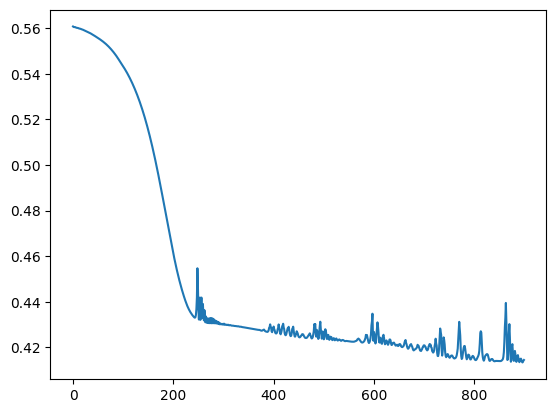

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(costs[100:])

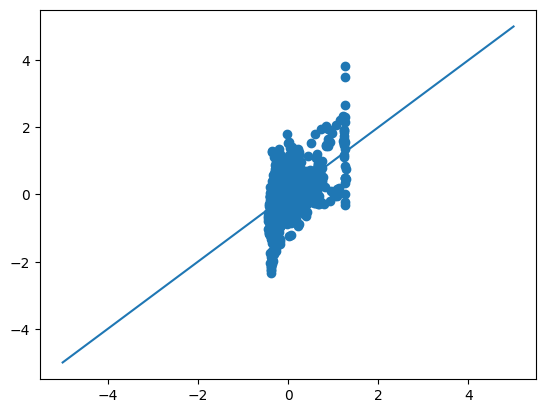

In [11]:
plt.scatter(predicted_energy,true_energy)
plt.plot([-5,5],[-5,5])